# NFL Betting

**Author:** Luis Santamaría

**Date:** September 11, 2025

---

On Sundays the lines go up, markets hum, and every game becomes a probability puzzle. We don’t chase vibes; we translate model signal into market-aware edges, pick one side per game, and let fractional Kelly do the quiet compounding—while skipping the early-season fog (Weeks 1–2) where noise masquerades as insight. The goal isn’t a hot streak; it’s a repeatable rhythm you can run every week without leaking tomorrow’s information into today’s decisions.

---

## Objective

Build and validate a **replicable, leak-free NFL betting pipeline** that:

1. converts model win probabilities into **market-aware EV** via game-level de-vig,
2. selects **one side per game** under a fixed edge threshold and an **EV floor that scales with odds**, and
3. sizes positions with **fractional Kelly under a weekly bankroll lock**—skipping Weeks 1–2 by design.
   This process is intended to be **re-run weekly** during the 2025 season with minimal changes.

---

## Research Questions

1. How does enforcing **no leakage** (strictly pre-game features) affect stability of edges across weeks?
2. Does **game-level de-vig** materially change EV vs. raw implied probabilities?
3. What is the impact of a **fixed edge threshold (τ)** and an **odds-scaled EV floor** on both yield and bet volume?
4. How do **weekly bankroll locking** and **fractional Kelly (0.25)** shape drawdowns and growth?
5. What balance delivers **\~70–90 bets after Week 2** with a positive expected yield?

---

## Working Hypotheses

* **Skipping Weeks 1–2** reduces variance and improves calibration because preseason signal is thin.
* **De-vig at the game level** (normalizing both moneylines) yields more honest market probabilities than 1/odds alone.
* A **fixed τ** plus an **odds-scaled EV floor** filters long-shot noise without crushing volume.
* **Weekly bankroll lock + Kelly caps** smooth exposure and support geometric growth.

---

## Scope and Limitations (Data Card)

* **Data sources (prepared beforehand):**
  `historical_odds.csv`, `target_odds.csv` (scores, home\_win), `team_pregame_features_historical.csv`, `ev_predictions.csv`
* **Coverage:** Full 2024 season backtest; procedure intended for 2025 replication.
* **Core fields:**
  `season, week, week_label, schedule_date, side, team, opponent, decimal_odds, model_prob, home_line, home_win/won`
* **Method guardrails:**

  * **No leakage:** all features are pre-game (rolling/YTD/EWM up to T-1).
  * **De-vig:** per-game normalization when both sides exist; raw implied prob if single side.
  * **Selection:** one pick per game; **τ fixed**, **EV floor increases with odds**; **Weeks 1–2 excluded**.
  * **Staking:** fractional Kelly (0.25), per-bet caps, **weekly bankroll lock**.
* **Limitations:**
  Backtests ignore book limits, line-shopping latency, and closing-line movement; market regimes may shift; playoffs have small samples.


# Step 1: Cleaning and Preparing Historical Betting Odds

When working with data, it is very common to discover that the raw information is messy, inconsistent, or even incomplete.  
That is exactly the case with our NFL betting dataset. At first glance, it looks rich: we have team names, final scores, spreads, and over/under lines. But once we dig a little deeper, we notice a few issues. The game dates, for example, come in different formats—some written with only two digits for the year, others using the full format. Older records from the 1970s and 1980s also lack proper betting data, making them less useful for modern predictive modeling.  

Since our ultimate goal is to build a model that can provide insights for current betting strategies, we need to focus on the most relevant and reliable part of the data: recent seasons. The NFL has evolved dramatically over the years—the style of play, the frequency of passing, even the way bookmakers set their lines has changed. A game from 1978 does not carry the same predictive value for today’s football environment.  

For that reason, in this step we will:  
- Standardize all game dates into a consistent format that Python can easily work with.  
- Keep only the seasons from 2019 to 2023, which reflect the modern era of the NFL.  
- Add two simple but powerful indicators: the point differential of each game, and whether the home team won or lost.  

By the end of this step, we will have a clean dataset that serves as a solid foundation for everything that comes next. This “polished” version of our data will allow us to combine it later with advanced performance metrics such as EPA/play, giving our model the structure it needs to learn from the past and make meaningful predictions about the future.

In [ ]:
import os, re, numpy as np, pandas as pd
import kagglehub
import IPython.display as disp

TARGET_SEASON = 2024
YEARS_BACK    = 4
OUT_PATH_HIST = "historical_odds.csv"
OUT_PATH_TGT  = "target_odds.csv"

path = kagglehub.dataset_download("tobycrabtree/nfl-scores-and-betting-data")

candidates = []
for root, _, files in os.walk(path):
    for f in files:
        if f.lower() == "spreadspoke_scores.csv":
            candidates.append(os.path.join(root, f))
if not candidates:
    # fallback laxo
    for root, _, files in os.walk(path):
        for f in files:
            if f.lower().endswith(".csv") and "spread" in f.lower() and "score" in f.lower():
                candidates.append(os.path.join(root, f))
if not candidates:
    raise FileNotFoundError("Couldn't find Kaggle dataset.")

SRC_CSV = candidates[0]

raw = pd.read_csv(SRC_CSV, low_memory=False)

raw.rename(columns={
    "schedule_date":"schedule_date",
    "schedule_season":"schedule_season",
    "schedule_week":"schedule_week",
    "team_home":"team_home",
    "team_away":"team_away",
    "team_favorite_id":"team_favorite_id",
    "spread_favorite":"spread_favorite",
    "over_under_line":"over_under_line",
    "score_home":"score_home",
    "score_away":"score_away",
}, inplace=True)

raw["schedule_date"] = pd.to_datetime(raw["schedule_date"], errors="coerce")

FULL_TO_ABBR = {
    "ARI":"ARI","ATL":"ATL","BAL":"BAL","BUF":"BUF","CAR":"CAR","CHI":"CHI","CIN":"CIN","CLE":"CLE",
    "DAL":"DAL","DEN":"DEN","DET":"DET","GB":"GB","HOU":"HOU","IND":"IND","JAX":"JAX","KC":"KC",
    "LA":"LA","LAC":"LAC","LV":"LV","MIA":"MIA","MIN":"MIN","NE":"NE","NO":"NO","NYG":"NYG","NYJ":"NYJ",
    "PHI":"PHI","PIT":"PIT","SEA":"SEA","SF":"SF","TB":"TB","TEN":"TEN","WAS":"WAS",
    "DALLAS COWBOYS":"DAL","NEW YORK GIANTS":"NYG","PHILADELPHIA EAGLES":"PHI",
    "WASHINGTON COMMANDERS":"WAS","WASHINGTON FOOTBALL TEAM":"WAS","WASHINGTON REDSKINS":"WAS",
    "CHICAGO BEARS":"CHI","DETROIT LIONS":"DET","GREEN BAY PACKERS":"GB","MINNESOTA VIKINGS":"MIN",
    "ATLANTA FALCONS":"ATL","CAROLINA PANTHERS":"CAR","NEW ORLEANS SAINTS":"NO","TAMPA BAY BUCCANEERS":"TB",
    "ARIZONA CARDINALS":"ARI","LOS ANGELES RAMS":"LA","LA RAMS":"LA","ST. LOUIS RAMS":"LA",
    "SAN FRANCISCO 49ERS":"SF","SEATTLE SEAHAWKS":"SEA",
    "BUFFALO BILLS":"BUF","MIAMI DOLPHINS":"MIA","NEW ENGLAND PATRIOTS":"NE","NEW YORK JETS":"NYJ",
    "BALTIMORE RAVENS":"BAL","CINCINNATI BENGALS":"CIN","CLEVELAND BROWNS":"CLE","PITTSBURGH STEELERS":"PIT",
    "HOUSTON TEXANS":"HOU","INDIANAPOLIS COLTS":"IND","JACKSONVILLE JAGUARS":"JAX","TENNESSEE TITANS":"TEN",
    "DENVER BRONCOS":"DEN","KANSAS CITY CHIEFS":"KC","LOS ANGELES CHARGERS":"LAC","LA CHARGERS":"LAC",
    "SAN DIEGO CHARGERS":"LAC","LAS VEGAS RAIDERS":"LV","OAKLAND RAIDERS":"LV",
}
for col in ["team_home","team_away","team_favorite_id"]:
    if col in raw.columns:
        raw[col] = raw[col].astype(str).str.upper().str.strip().map(lambda x: FULL_TO_ABBR.get(x, x))

PLAYOFF_MAP = {
    "WILD CARD":19,"WILDCARD":19,"WC":19,
    "DIVISION":20,"DIV":20,"DIVISIONAL":20,
    "CONFERENCE":21,"CONF":21,"CHAMPIONSHIP":21,"CONF CHAMPIONSHIP":21,
    "SUPER BOWL":22,"SUPERBOWL":22,"SB":22
}
def normalize_week_to_num(x):
    if pd.isna(x): return np.nan
    s = str(x).strip().upper()
    m = re.search(r"(\d+)", s)
    if m: return int(m.group(1))
    return PLAYOFF_MAP.get(s, np.nan)

def week_num_to_label(n):
    if pd.isna(n): return None
    n = int(n)
    if 1 <= n <= 18: return f"Week {n}"
    return {19:"Wild Card",20:"Divisional",21:"Conference",22:"Super Bowl"}.get(n, f"Week {n}")

raw["week"] = raw["schedule_week"].apply(normalize_week_to_num)
raw = raw.dropna(subset=["schedule_season","week"])
raw["schedule_season"] = raw["schedule_season"].astype(int)
raw["week"] = raw["week"].astype(int)
raw["week_label"] = raw["week"].apply(week_num_to_label)

hist_start = TARGET_SEASON - YEARS_BACK
hist_end   = TARGET_SEASON - 1
cand = raw[(raw["schedule_season"] >= hist_start) & (raw["schedule_season"] <= hist_end)].copy()

full_seasons = []
for y in range(hist_start, hist_end+1):
    has_sb = (cand["schedule_season"].eq(y) & cand["week"].eq(22)).any()
    if has_sb:
        full_seasons.append(y)
    else:
        print(f"⚠️ Season {y} incomplete.")

hist = cand[cand["schedule_season"].isin(full_seasons)].copy()
if hist.empty:
    raise RuntimeError("No complete seasons in given range.")

hist["score_home"] = pd.to_numeric(hist["score_home"], errors="coerce")
hist["score_away"] = pd.to_numeric(hist["score_away"], errors="coerce")
hist["point_diff"] = hist["score_home"] - hist["score_away"]
hist["home_win"]   = (hist["point_diff"] > 0).astype(int)
hist["spread_favorite"] = pd.to_numeric(hist["spread_favorite"], errors="coerce")

def home_line_row(r):
    fav = r.get("team_favorite_id", "")
    s   = r.get("spread_favorite", np.nan)
    if pd.isna(s): return np.nan
    if fav == r["team_home"]:
        return float(s)
    elif fav == r["team_away"]:
        return float(-s)
    else:
        return np.nan

hist["home_line"] = hist.apply(home_line_row, axis=1)

hist = hist.rename(columns={
    "schedule_season":"season",
    "team_home":"home_team",
    "team_away":"away_team",
})
keep_cols = [
    "schedule_date","season","week","week_label",
    "home_team","score_home","score_away",
    "away_team","team_favorite_id","spread_favorite","home_line",
    "over_under_line","weather_temperature","weather_wind_mph","weather_humidity",
    "stadium","stadium_neutral","point_diff","home_win"
]
keep_cols = [c for c in keep_cols if c in hist.columns]
df_hist = hist[keep_cols].copy()

df_hist["schedule_date"] = pd.to_datetime(df_hist["schedule_date"], errors="coerce")
df_hist = df_hist.sort_values(["season","week","schedule_date","home_team"]).reset_index(drop=True)

df_hist.to_csv(OUT_PATH_HIST, index=False)
print("Historical Odds Dataset: ")
disp.display(df_hist.head(10))

tgt = raw[raw["schedule_season"] == TARGET_SEASON].copy()
if tgt.empty:
    print(f"No data for TARGET_SEASON={TARGET_SEASON} in Kaggle.")
else:
    tgt["score_home"] = pd.to_numeric(tgt["score_home"], errors="coerce")
    tgt["score_away"] = pd.to_numeric(tgt["score_away"], errors="coerce")
    tgt["point_diff"] = tgt["score_home"] - tgt["score_away"]
    tgt["home_win"]   = np.where(tgt["score_home"].notna() & tgt["score_away"].notna(),
                                 (tgt["point_diff"] > 0).astype(int), np.nan)
    tgt["spread_favorite"] = pd.to_numeric(tgt["spread_favorite"], errors="coerce")
    tgt["home_line"] = tgt.apply(home_line_row, axis=1)

    tgt = tgt.rename(columns={
        "schedule_season":"season",
        "team_home":"home_team",
        "team_away":"away_team",
    })
    keep_cols_tgt = [c for c in keep_cols if c in tgt.columns]
    df_target = tgt[keep_cols_tgt].copy()
    df_target["schedule_date"] = pd.to_datetime(df_target["schedule_date"], errors="coerce")
    df_target = df_target.sort_values(["season","week","schedule_date","home_team"]).reset_index(drop=True)

    df_target.to_csv(OUT_PATH_TGT, index=False)

100%|██████████| 246k/246k [00:00<00:00, 25.3MB/s]

Extracting files...


Historical Odds Dataset: 


,schedule_date,season,week,week_label,home_team,score_home,score_away,away_team,team_favorite_id,spread_favorite,home_line,over_under_line,weather_temperature,weather_wind_mph,weather_humidity,stadium,stadium_neutral,point_diff,home_win
0,2020-09-10,2020,1,Week 1,KC,34,20,HOU,KC,-9.0,-9.0,54,NaN,NaN,NaN,Arrowhead Stadium,False,14,1
1,2020-09-13,2020,1,Week 1,ATL,25,38,SEA,SEA,-1.0,1.0,49,72.0,0.0,NaN,Mercedes-Benz Stadium,False,-13,0
2,2020-09-13,2020,1,Week 1,BAL,38,6,CLE,BAL,-7.0,-7.0,47.5,NaN,NaN,NaN,M&T Bank Stadium,False,32,1
3,2020-09-13,2020,1,Week 1,BUF,27,17,NYJ,BUF,-6.5,-6.5,39.5,NaN,NaN,NaN,New Era Field,False,10,1
4,2020-09-13,2020,1,Week 1,CAR,30,34,LV,LVR,-3.0,NaN,48,NaN,NaN,NaN,Bank of America Stadium,False,-4,0
5,2020-09-13,2020,1,Week 1,CIN,13,16,LAC,LAC,-3.0,3.0,41.5,NaN,NaN,NaN,Paul Brown Stadium,False,-3,0
6,2020-09-13,2020,1,Week 1,DET,23,27,CHI,DET,-2.5,-2.5,42.5,72.0,0.0,NaN,Ford Field,False,-4,0
7,2020-09-13,2020,1,Week 1,JAX,27,20,IND,IND,-8.0,8.0,45,NaN,NaN,NaN,TIAA Bank Field,False,7,1
8,2020-09-13,2020,1,Week 1,LA,20,17,DAL,DAL,-2.0,2.0,51.5,72.0,0.0,NaN,SoFi Stadium,False,3,1
9,2020-09-13,2020,1,Week 1,MIN,34,43,GB,MIN,-2.5,-2.5,44.5,72.0,0.0,NaN,U.S. Bank Stadium,False,-9,0


# Step 2: Building Team-Level Performance Metrics

When analyzing NFL play-by-play data, the raw numbers might look overwhelming at first: thousands of rows per game, every pass, every run, every penalty. On their own, these granular events tell us what happened in each snap, but not necessarily how well a team performed across an entire game. Just like trying to understand a movie by looking at individual frames, the bigger picture can easily get lost in the details.  

That’s where aggregation comes in. Instead of focusing on isolated plays, we combine them to create higher-level metrics that capture overall efficiency. One of the most powerful of these is **Expected Points Added (EPA)**, which goes beyond simple yardage by incorporating game context—down, distance, and field position. EPA allows us to measure the true value of each play in terms of points, and by averaging across plays, we get a sense of how effective an offense or defense was over the course of a game.  

But football is more than just EPA. Yardage per play, success rates, explosive plays, and third-down conversions are also critical indicators of team strength. A team that racks up yards but struggles on third down may look efficient on paper, but fail to sustain drives when it matters most. By blending both advanced and traditional metrics, we ensure that our dataset reflects the full complexity of the game.  

In this step, we will:  
- Collect play-by-play data from 2019 to 2024, representing the modern NFL era.  
- Aggregate plays into team-level game summaries, both offensive and defensive.  
- Compute a wide set of performance features: EPA/play, yards per play, success rate, explosive play rate, and third-down conversion efficiency.  

By the end of this step, we will no longer be staring at isolated snapshots of the NFL. Instead, we will hold a polished table where each row represents how a team performed in a given game—ready to be merged with betting odds, weather data, or any other contextual variables in later steps of our modeling process.

In [ ]:
import io, gzip, requests, pandas as pd, numpy as np, warnings
from IPython.display import display

warnings.filterwarnings("ignore")

try:
    TARGET_SEASON
except NameError:
    TARGET_SEASON = 2024

HIST_START = TARGET_SEASON - 4
YEARS = list(range(HIST_START, TARGET_SEASON + 1))

def fetch_year_any(year: int) -> pd.DataFrame:
    parq = f"https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{year}.parquet"
    csvgz = f"https://github.com/nflverse/nflverse-data/releases/download/pbp/play_by_play_{year}.csv.gz"
    try:
        r = requests.get(parq, timeout=120); r.raise_for_status()
        return pd.read_parquet(io.BytesIO(r.content))
    except Exception:
        r = requests.get(csvgz, timeout=180); r.raise_for_status()
        with gzip.GzipFile(fileobj=io.BytesIO(r.content)) as gz:
            return pd.read_csv(gz, low_memory=False)

frames = []
for y in YEARS:
    try:
        frames.append(fetch_year_any(y))
    except Exception:
        pass
if not frames:
    raise RuntimeError("Could not download any PBP season from nflverse.")
pbp = pd.concat(frames, ignore_index=True)

need = [
    'game_id','game_date','season','week','season_type',
    'home_team','away_team','posteam','defteam',
    'play_type','epa','yards_gained','down','first_down',
    'air_yards','yards_after_catch'
]
pbp = pbp[[c for c in need if c in pbp.columns]].copy()
pbp['season_type'] = pbp.get('season_type', 'REG').astype(str).str.upper().str.strip()
pbp = pbp[~pbp['season_type'].str.contains('PRE')].copy()
pbp['week'] = pbp['week'].astype(int)

def normalize_week(season_type, w):
    st = str(season_type).upper(); w = int(w)
    if 'POST' in st:
        if 19 <= w <= 22: return w
        return {1:19, 2:20, 3:21, 4:22, 5:22, 0:19}.get(w, w)
    return 1 if w < 1 else (18 if w > 18 else w)

pbp['week'] = [normalize_week(st, w) for st, w in zip(pbp['season_type'], pbp['week'])]
pbp = pbp[pbp['play_type'].isin(['pass','run']) & pbp['epa'].notna()].copy()
pbp['game_date'] = pd.to_datetime(pbp.get('game_date', pd.NaT), errors="coerce")

is_pass = pbp['play_type'].eq('pass')
is_run  = pbp['play_type'].eq('run')
explosive = (is_pass & (pbp['yards_gained'] >= 20)) | (is_run & (pbp['yards_gained'] >= 10))
pbp = pbp.assign(
    success=(pbp['epa'] > 0).astype(int),
    explosive=explosive.astype(int),
    third_down=(pbp['down'] == 3).astype(int),
    third_down_conv=((pbp['down'] == 3) & pbp['first_down'].fillna(False)).astype(int)
)

gb_off = ['game_id','season','week','posteam']
gb_def = ['game_id','season','week','defteam']

off = (pbp.groupby(gb_off, as_index=False)
       .agg(
           off_epa_per_play=('epa','mean'),
           off_plays=('epa','size'),
           off_yards_per_play=('yards_gained','mean'),
           off_success_rate=('success','mean'),
           off_explosive_rate=('explosive','mean'),
           off_third_down_rate=('third_down','mean'),
           off_third_down_conv_rate=('third_down_conv','mean'),
       ).rename(columns={'posteam':'team'}))

defn = (pbp.groupby(gb_def, as_index=False)
        .agg(
            def_epa_allowed=('epa','mean'),
            def_plays=('epa','size'),
            def_yards_per_play_allowed=('yards_gained','mean'),
            def_success_rate_allowed=('success','mean'),
            def_explosive_rate_allowed=('explosive','mean'),
            def_third_down_rate_allowed=('third_down','mean'),
            def_third_down_conv_rate_allowed=('third_down_conv','mean'),
        ).rename(columns={'defteam':'team'}))

off_pass = (pbp[is_pass].groupby(gb_off, as_index=False)
    .agg(
        off_pass_epa=('epa','mean'),
        off_pass_plays=('epa','size'),
        off_pass_yards_per_att=('yards_gained','mean'),
        off_pass_success_rate=('success','mean'),
        off_pass_explosive_rate=('explosive','mean'),
        off_air_yards_per_att=('air_yards', lambda x: x.dropna().mean() if x.dropna().size else np.nan),
        off_yac_per_rec=('yards_after_catch', lambda x: x.dropna().mean() if x.dropna().size else np.nan),
    ).rename(columns={'posteam':'team'}))

off_rush = (pbp[is_run].groupby(gb_off, as_index=False)
    .agg(
        off_rush_epa=('epa','mean'),
        off_rush_plays=('epa','size'),
        off_rush_yards_per_att=('yards_gained','mean'),
        off_rush_success_rate=('success','mean'),
        off_rush_explosive_rate=('explosive','mean'),
    ).rename(columns={'posteam':'team'}))

def_pass = (pbp[is_pass].groupby(gb_def, as_index=False)
    .agg(
        def_pass_epa_allowed=('epa','mean'),
        def_pass_plays=('epa','size'),
        def_pass_yards_per_att_allowed=('yards_gained','mean'),
        def_pass_success_rate_allowed=('success','mean'),
        def_pass_explosive_rate_allowed=('explosive','mean'),
        def_air_yards_per_att_allowed=('air_yards', lambda x: x.dropna().mean() if x.dropna().size else np.nan),
        def_yac_per_rec_allowed=('yards_after_catch', lambda x: x.dropna().mean() if x.dropna().size else np.nan),
    ).rename(columns={'defteam':'team'}))

def_rush = (pbp[is_run].groupby(gb_def, as_index=False)
    .agg(
        def_rush_epa_allowed=('epa','mean'),
        def_rush_plays=('epa','size'),
        def_rush_yards_per_att_allowed=('yards_gained','mean'),
        def_rush_success_rate_allowed=('success','mean'),
        def_rush_explosive_rate_allowed=('explosive','mean'),
    ).rename(columns={'defteam':'team'}))

game_dates = pbp[['game_id','game_date']].drop_duplicates('game_id')

team_game = (off.merge(off_pass, on=['game_id','season','week','team'], how='left')
                .merge(off_rush, on=['game_id','season','week','team'], how='left')
                .merge(defn,     on=['game_id','season','week','team'], how='left')
                .merge(def_pass, on=['game_id','season','week','team'], how='left')
                .merge(def_rush, on=['game_id','season','week','team'], how='left')
                .merge(game_dates, on='game_id', how='left'))

team_game = team_game[(team_game['off_plays']>=10) & (team_game['def_plays']>=10)].copy()
TEAM_FIX = {"STL":"LA","LAR":"LA","SD":"LAC","SDG":"LAC","OAK":"LV","LVR":"LV","WSH":"WAS","JAC":"JAX"}
team_game['team'] = team_game['team'].astype(str).str.upper().str.strip().map(lambda x: TEAM_FIX.get(x, x))
team_game = team_game.sort_values(['team','season','game_date','game_id']).reset_index(drop=True)

metric_cols = [c for c in team_game.columns if c not in ['game_id','season','week','team','game_date']]

def build_pregame_one_season(df_team_season: pd.DataFrame) -> pd.DataFrame:
    out = df_team_season[['game_id','season','week','team','game_date']].copy()
    for c in metric_cols:
        s_prev = df_team_season[c].shift(1)
        out[c + '_pre_ytd'] = s_prev.expanding(min_periods=1).mean()
        out[c + '_pre_ewm'] = s_prev.ewm(alpha=0.35, adjust=False).mean()
        out[c + '_pre_l8']  = s_prev.rolling(window=8, min_periods=1).mean()
    return out

cols_for_apply = ['game_id','season','week','team','game_date'] + metric_cols
pregame = (team_game.groupby(['team','season'], group_keys=False, sort=False)[cols_for_apply]
           .apply(build_pregame_one_season)
           .reset_index(drop=True))

pregame['week'] = pregame['week'].astype(int)
pregame = pregame.sort_values(['game_date','team','game_id']).reset_index(drop=True)

pregame.to_csv("team_pregame_features_historical.csv", index=False)

disp = pregame.query("week >= 2 and week <= 18").sort_values(['game_date','team','game_id']).head(10)
print("Team Stats Dataset: ")
display(disp)

# Step 3: Merging Betting Odds with Team Efficiency Metrics

At this point, we have two different lenses on the NFL. The odds dataset captures the market’s expectations—who was favored, by how much, and what kind of scoring environment the sportsbooks anticipated. The efficiency dataset, in contrast, tells us how teams actually performed on the field, measured through advanced metrics like EPA/play, yards per play, and success rates.

Individually, each dataset is useful. The odds reflect predictions, while efficiency reflects reality. But the real value emerges when we merge them together. By aligning the market’s expectations with on-field performance, we open the door to discovering mismatches—those moments when the betting line underestimated or overestimated a team’s true strength.

In this step, we will:
- Standardize team identifiers so that both datasets speak the same language.
- Reshape the efficiency metrics so that each game is represented in a single row with both home and away stats.
- Merge the odds and efficiency datasets for the 2019–2024 seasons into one unified master table.

By the end of this step, we will have a dataset where every game tells two stories at once: what the market thought would happen, and what actually unfolded on the field.

In [ ]:
import os, time, numpy as np, pandas as pd, requests, warnings
from IPython.display import display

warnings.filterwarnings("ignore")

TARGET_SEASON   = globals().get("TARGET_SEASON", 2024)
ODDS_HIST_PATH  = "historical_odds.csv"
TARGET_ODDS_PATH= "target_odds.csv"
PREG_PATH       = "team_pregame_features_historical.csv"

API_KEY = "cef868f4974543ed9854d7ada381f7e1"
HEADERS = {"Ocp-Apim-Subscription-Key": API_KEY}
BASES = [
    "https://api.sportsdata.io/v3/nfl/odds/json/GameOddsByWeekV3/{season}/{stype}/{week}",
    "https://api.sportsdata.io/v3/nfl/odds/json/GameOddsByWeek/{season}/{week}?seasontype={stype}",
    "https://api.sportsdata.io/v3/nfl/odds/json/GameOddsByWeek/{season}/{week}",
]

TEAM_FIX = {
    "STL":"LA","LAR":"LA","SD":"LAC","SDG":"LAC","OAK":"LV","LVR":"LV","WSH":"WAS","JAC":"JAX",
    "GNB":"GB","KAN":"KC","NWE":"NE","NOR":"NO","SFO":"SF","TAM":"TB"
}

def norm_team(s: str) -> str:
    s = str(s).upper().strip()
    return TEAM_FIX.get(s, s)

def week_label_from_num(n:int) -> str:
    return f"Week {n}" if 1<=n<=18 else {19:"Wild Card",20:"Divisional",21:"Conference",22:"Super Bowl"}.get(n, f"Week {n}")

def to_global_week(stype, wk):
    stype = int(stype); wk = int(wk)
    return wk if stype==1 else 18+wk

def american_to_decimal(m):
    if m is None or (isinstance(m,float) and np.isnan(m)): return np.nan
    m = float(m)
    return 1 + (100/abs(m) if m<0 else m/100)

def compute_market_probs(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    if "decimal_home" not in out.columns: out["decimal_home"] = np.nan
    if "decimal_away" not in out.columns: out["decimal_away"] = np.nan
    mh = out["decimal_home"].astype(float)
    ma = out["decimal_away"].astype(float)
    out["market_prob_home_raw"] = 1.0 / mh
    out["market_prob_away_raw"] = 1.0 / ma
    s = out[["market_prob_home_raw","market_prob_away_raw"]].sum(axis=1, min_count=1)
    out["market_prob_home_nv"] = out["market_prob_home_raw"] / s
    out["market_prob_away_nv"] = out["market_prob_away_raw"] / s
    for c in ["market_prob_home_raw","market_prob_away_raw","market_prob_home_nv","market_prob_away_nv"]:
        out[c] = out[c].clip(1e-6, 1-1e-6)
    return out

def ensure_home_line_from_odds(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    if "home_line" not in df.columns:
        if "spread_home" in df.columns:
            df["home_line"] = pd.to_numeric(df["spread_home"], errors="coerce")
        else:
            dec_h = pd.to_numeric(df.get("decimal_home", np.nan), errors="coerce")
            dec_a = pd.to_numeric(df.get("decimal_away", np.nan), errors="coerce")
            df["home_line"] = np.where(dec_h<dec_a, -2.5, 2.5)
    return df

def add_pref(df, prefix, key="team"):
    keep = ["season","week",key]
    ren  = {c: f"{prefix}{c}" for c in df.columns if c not in keep}
    return df.rename(columns=ren)

def build_master_from_kaggle(odds_df: pd.DataFrame, pre_df: pd.DataFrame, add_ml: bool=False, ml_df: pd.DataFrame=None) -> pd.DataFrame:
    out = odds_df.copy()
    for c in ("home_team","away_team","team_favorite_id"):
        if c in out.columns: out[c] = out[c].map(norm_team)
    out["season"] = out["season"].astype(int)
    out["week"]   = out["week"].astype(int)
    if "week_label" not in out.columns:
        out["week_label"] = out["week"].apply(week_label_from_num)

    if add_ml and ml_df is not None and not ml_df.empty:
        ml = ml_df.copy()
        ml["home_team"] = ml["home_team"].map(norm_team)
        ml["away_team"] = ml["away_team"].map(norm_team)
        ml["season"]    = ml["season"].astype(int)
        ml["week"]      = ml["week"].astype(int)
        out = (out.merge(ml[["season","week","home_team","away_team","ml_home","ml_away","decimal_home","decimal_away"]],
                         on=["season","week","home_team","away_team"], how="left"))
        out = compute_market_probs(out)

    out = ensure_home_line_from_odds(out)

    pre = pre_df.copy()
    pre["team"]   = pre["team"].map(norm_team)
    pre["season"] = pre["season"].astype(int)
    pre["week"]   = pre["week"].astype(int)
    pre = (pre.sort_values(["season","week","team"])
             .drop_duplicates(["season","week","team"], keep="last"))

    home_pre = add_pref(pre.rename(columns={"team":"home_team"}), "home_", key="home_team")
    away_pre = add_pref(pre.rename(columns={"team":"away_team"}), "away_", key="away_team")

    m = (out.merge(home_pre, on=["season","week","home_team"], how="left")
            .merge(away_pre, on=["season","week","away_team"], how="left"))

    if "schedule_date" in m.columns:
        m["schedule_date"] = pd.to_datetime(m["schedule_date"], errors="coerce")
    m = m.sort_values(["schedule_date","season","week","home_team"]).reset_index(drop=True)
    return m

def pick(o, *keys):
    for k in keys:
        if k in o and o[k] not in (None, ""):
            return o[k]
    return None

def parse_one_odd(game, odd, stype, wk):
    ht = (pick(odd,"HomeTeam","HomeTeamKey","HomeTeamName") or pick(game,"HomeTeam","HomeTeamName") or "").upper().strip()
    at = (pick(odd,"AwayTeam","AwayTeamKey","AwayTeamName") or pick(game,"AwayTeam","AwayTeamName") or "").upper().strip()
    ml_h = pick(odd,"MoneyLineHome","HomeMoneyLine","MoneylineHome","HomeTeamMoneyLine","HomeTeamMoneyline","HomeMl","MoneyLineHomeOpen")
    ml_a = pick(odd,"MoneyLineAway","AwayMoneyLine","MoneylineAway","AwayTeamMoneyLine","AwayTeamMoneyline","AwayMl","MoneyLineAwayOpen")
    sp_h = pick(odd,"PointSpreadHome","SpreadHome","HomePointSpread","HomeSpread","HomeLine")
    sp_a = pick(odd,"PointSpreadAway","SpreadAway","AwayPointSpread","AwaySpread","AwayLine")
    ou   = pick(odd,"OverUnder","TotalNumber","Total","OverUnderTotal")
    return {
        "season": TARGET_SEASON,
        "season_type": int(stype),
        "week_st": int(wk),
        "week": to_global_week(stype, wk),
        "start": pick(game, "DateTime", "Day"),
        "home_team": ht, "away_team": at,
        "ml_home": pd.to_numeric(ml_h, errors="coerce"),
        "ml_away": pd.to_numeric(ml_a, errors="coerce"),
        "spread_home": pd.to_numeric(sp_h, errors="coerce"),
        "spread_away": pd.to_numeric(sp_a, errors="coerce"),
        "over_under_line": pd.to_numeric(ou, errors="coerce"),
    }

def fetch_week(season, stype, wk):
    rows = []
    for base in BASES:
        url = base.format(season=season, stype=stype, week=wk)
        try:
            r = requests.get(url, headers=HEADERS, timeout=30)
        except Exception:
            continue
        if r.status_code != 200:
            continue
        data = r.json()
        for g in data:
            odds_list = g.get("PregameOdds") or g.get("AlternateMarketPregameOdds") or []
            for o in odds_list:
                rows.append(parse_one_odd(g, o, stype, wk))
        break
    return rows

def fetch_ml_for_target(season):
    all_rows = []
    for stype, weeks in [(1, range(1,19)), (3, range(1,5))]:
        for wk in weeks:
            all_rows.extend(fetch_week(season, stype, wk))
            time.sleep(0.35)
    df = pd.DataFrame(all_rows)
    if df.empty:
        return df
    df["home_team"] = df["home_team"].map(norm_team)
    df["away_team"] = df["away_team"].map(norm_team)
    df["decimal_home"] = df["ml_home"].apply(american_to_decimal)
    df["decimal_away"] = df["ml_away"].apply(american_to_decimal)
    ml = (df.groupby(["season","week","home_team","away_team"], as_index=False)
            .agg({
                "ml_home":"mean","ml_away":"mean",
                "decimal_home":"mean","decimal_away":"mean"
            }))
    return ml

for pth in (ODDS_HIST_PATH, TARGET_ODDS_PATH, PREG_PATH):
    if not os.path.exists(pth):
        raise FileNotFoundError(f"Missing '{pth}'.")

odds_hist   = pd.read_csv(ODDS_HIST_PATH, low_memory=False)
target_odds = pd.read_csv(TARGET_ODDS_PATH, low_memory=False)
preg_all    = pd.read_csv(PREG_PATH, low_memory=False)

preg_hist = preg_all[preg_all["season"] <= TARGET_SEASON-1].copy()
preg_2024 = preg_all[preg_all["season"] == TARGET_SEASON].copy()

ml_2024 = fetch_ml_for_target(TARGET_SEASON)
master_hist  = build_master_from_kaggle(odds_hist,   preg_hist,  add_ml=False, ml_df=None)
master_2024  = build_master_from_kaggle(target_odds, preg_2024, add_ml=True,  ml_df=ml_2024)

base_cols = [c for c in [
    "schedule_date","season","week","week_label",
    "home_team","away_team","team_favorite_id","spread_favorite",
    "home_line","over_under_line","score_home","score_away","home_win",
    "decimal_home","decimal_away","ml_home","ml_away",
    "market_prob_home_nv","market_prob_away_nv"
] if c in master_hist.columns]

print("Master Dataset: ")
display(master_hist[base_cols].head(12))

Master Dataset: 


,schedule_date,season,week,week_label,home_team,away_team,team_favorite_id,spread_favorite,home_line,over_under_line,score_home,score_away,home_win
0,2020-09-10,2020,1,Week 1,KC,HOU,KC,-9.0,-9.0,54.0,34,20,1
1,2020-09-13,2020,1,Week 1,ATL,SEA,SEA,-1.0,1.0,49.0,25,38,0
2,2020-09-13,2020,1,Week 1,BAL,CLE,BAL,-7.0,-7.0,47.5,38,6,1
3,2020-09-13,2020,1,Week 1,BUF,NYJ,BUF,-6.5,-6.5,39.5,27,17,1
4,2020-09-13,2020,1,Week 1,CAR,LV,LV,-3.0,NaN,48.0,30,34,0
5,2020-09-13,2020,1,Week 1,CIN,LAC,LAC,-3.0,3.0,41.5,13,16,0
6,2020-09-13,2020,1,Week 1,DET,CHI,DET,-2.5,-2.5,42.5,23,27,0
7,2020-09-13,2020,1,Week 1,JAX,IND,IND,-8.0,8.0,45.0,27,20,1
8,2020-09-13,2020,1,Week 1,LA,DAL,DAL,-2.0,2.0,51.5,20,17,1
9,2020-09-13,2020,1,Week 1,MIN,GB,MIN,-2.5,-2.5,44.5,34,43,0


# Step 4: First Baseline Model — Turning Signals into Predictions

Now that we’ve stitched together the market’s expectations and on-field performance, it’s time to ask a simple question: *given what the market thought and how these teams typically play, who is going to win the game?* This isn’t our final model, but it’s an essential first step—a baseline that helps us understand signal strength, data quality, and where the model might struggle.

To keep things honest, we’ll respect time. We’ll train on seasons 2019–2022, validate on 2023, and test on 2024. That way, our model only “sees” the past and proves itself on the future. We’ll start with straightforward algorithms—a regularized logistic regression and a random forest—because they’re transparent enough to debug and strong enough to set a bar.

By the end of this step, we’ll have a working predictor of home win probability, evaluation metrics across seasons, and a short list of features that matter most. This gives us a grounded baseline before we move on to calibration, spread coverage, expected value, and simulation.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.isotonic import IsotonicRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
import re

assert 'master_hist' in globals(), "Falta master_hist (Step 3)."
assert 'master_2024' in globals(), "Falta master_2024 (Step 3)."

TARGET_SEASON = globals().get("TARGET_SEASON", 2024)

df = pd.concat([master_hist.copy(), master_2024.copy()], ignore_index=True)

df["season"] = pd.to_numeric(df["season"], errors="coerce").astype("Int64")
df["week"]   = pd.to_numeric(df["week"],   errors="coerce").astype("Int64")

def compute_home_line(r):
    s  = r.get("spread_favorite", np.nan)
    tf = str(r.get("team_favorite_id", ""))
    if pd.isna(s) or tf == "" or tf == "nan":
        return r.get("home_line", np.nan)
    if tf == r["home_team"]:
        return float(s)
    if tf == r["away_team"]:
        return float(-s)
    return r.get("home_line", np.nan)

if "home_line" not in df.columns or df["home_line"].isna().any():
    df["home_line"] = df.apply(compute_home_line, axis=1)

df["abs_spread"] = df["home_line"].astype(float).abs()
df["fav_home"]   = (df["home_line"].astype(float) < 0).astype(int)
df["ou"]         = df.get("over_under_line", np.nan).astype(float)

df["spread_x_ou"]   = df["abs_spread"] * df["ou"]
df["fav_x_spread"]  = df["fav_home"]   * df["abs_spread"]
df["home_line_sq"]  = df["home_line"]  * df["home_line"]

pre_cols = [c for c in df.columns
            if re.search(r'(?:_pre$|_pre_ytd$|_pre_ewm$|_pre_l8$)', c)]
mkt_cols = [c for c in ["home_line","abs_spread","fav_home","ou",
                        "spread_x_ou","fav_x_spread","home_line_sq"]
            if c in df.columns]
feat_cols = [c for c in (pre_cols + mkt_cols) if c in df.columns]

hist_years = sorted(df.loc[df["season"] < TARGET_SEASON, "season"].dropna().unique().tolist())
assert len(hist_years) >= 2, "Need at least 2 seasons to train/val."

val_year   = hist_years[-1]
train_years= hist_years[:-1]
test_year  = TARGET_SEASON

base = df.dropna(subset=["home_line"]).copy()

train_df = base[base["season"].isin(train_years)].copy()
val_df   = base[base["season"].eq(val_year)].copy()
test_df  = base[base["season"].eq(test_year)].copy()

y_train = train_df["home_win"].astype(int).values
y_val   = val_df["home_win"].astype(int).values
y_test_series = test_df["home_win"] if "home_win" in test_df.columns else pd.Series(dtype="float")

X_train = train_df[feat_cols].copy()
X_val   = val_df[feat_cols].copy()
X_test  = test_df[feat_cols].copy()

train_meds = X_train.median(numeric_only=True)
X_train = X_train.fillna(train_meds)
X_val   = X_val.fillna(train_meds)
X_test  = X_test.fillna(train_meds)

monotonic_cst = [(-1 if c == "home_line" else 0) for c in feat_cols]

hgb = HistGradientBoostingClassifier(
    learning_rate=0.06,
    max_leaf_nodes=21,
    min_samples_leaf=60,
    l2_regularization=2.0,
    max_iter=320,
    early_stopping=True,
    validation_fraction=0.15,
    n_iter_no_change=40,
    monotonic_cst=monotonic_cst,
    random_state=42
)
hgb.fit(X_train, y_train)

p_tr = hgb.predict_proba(X_train)[:,1]
p_va = hgb.predict_proba(X_val)[:,1]
p_te = hgb.predict_proba(X_test)[:,1] if len(X_test) else np.array([])

bin_edges = [-21, -10.5, -6.5, -3.5, -0.5, 0.5, 3.5, 6.5, 10.5, 21]
def cut_bins(x):
    return pd.cut(x, bins=bin_edges, include_lowest=True)

val_bins  = cut_bins(val_df["home_line"])
test_bins = cut_bins(test_df["home_line"]) if len(test_df) else pd.Series(dtype="category")

iso_global = IsotonicRegression(out_of_bounds="clip")
iso_global.fit(p_va, y_val)

bin_min = 120
iso_by_bin = {}
for b in val_bins.unique():
    idx = (val_bins == b)
    if idx.sum() >= bin_min:
        iso = IsotonicRegression(out_of_bounds="clip")
        iso.fit(p_va[idx], y_val[idx])
        iso_by_bin[b] = iso

def apply_bin_calibration(p_raw, bins_series):
    if len(p_raw) == 0:
        return p_raw
    out = np.empty_like(p_raw, dtype=float)
    if not iso_by_bin:
        return np.clip(iso_global.transform(p_raw), 1e-6, 1-1e-6)
    for b in bins_series.unique():
        m = (bins_series == b).values
        if b in iso_by_bin:
            out[m] = iso_by_bin[b].transform(p_raw[m])
        else:
            out[m] = iso_global.transform(p_raw[m])
    return np.clip(out, 1e-6, 1-1e-6)

p_tr_cal = iso_global.transform(p_tr)
p_va_cal = apply_bin_calibration(p_va, val_bins)
p_te_cal = apply_bin_calibration(p_te, test_bins)

prior_lr = LogisticRegression(C=2.0, solver="liblinear", max_iter=200)
prior_lr.fit(train_df[["home_line"]], y_train)

p_tr_sp = prior_lr.predict_proba(train_df[["home_line"]])[:,1]
p_va_sp = prior_lr.predict_proba(val_df[["home_line"]])[:,1]
p_te_sp = prior_lr.predict_proba(test_df[["home_line"]])[:,1] if len(test_df) else np.array([])

def meta_matrix(df_in, p_hgb_cal, p_spread):
    M = pd.DataFrame({
        "p_hgb":   p_hgb_cal,
        "p_sp":    p_spread,
        "home_line": df_in["home_line"].values,
        "abs_spread": df_in["abs_spread"].values,
        "ou": df_in["ou"].values
    })
    return M.fillna(M.median(numeric_only=True))

meta_tr   = meta_matrix(train_df, p_tr_cal, p_tr_sp)
meta_val  = meta_matrix(val_df,   p_va_cal, p_va_sp)
meta_test = meta_matrix(test_df,  p_te_cal, p_te_sp) if len(test_df) else pd.DataFrame()

meta_lr = LogisticRegression(C=1.0, solver="liblinear", max_iter=300)
meta_lr.fit(meta_val, y_val)

p_tr_meta = np.clip(meta_lr.predict_proba(meta_tr)[:,1], 1e-6, 1-1e-6)
p_va_meta = np.clip(meta_lr.predict_proba(meta_val)[:,1], 1e-6, 1-1e-6)
p_te_meta = (np.clip(meta_lr.predict_proba(meta_test)[:,1], 1e-6, 1-1e-6)
             if len(meta_test) else np.array([]))

print("Model Results: ")
def show(tag, y, p):
    acc = accuracy_score(y, (p>=0.5).astype(int))
    auc = roc_auc_score(y, p)
    ll  = log_loss(y, p)
    print(f"{tag:5s} | ACC {acc:.3f} | ROC_AUC {auc:.3f} | LOGLOSS {ll:.3f}")

show("train", y_train, p_tr_meta)
show("val",   y_val,   p_va_meta)

if y_test_series.notna().any():
    y_test = y_test_series.dropna().astype(int).values
    show("test", y_test, p_te_meta)
else:
    print("test  | no lables for test season")


test_preds = test_df[["season","week","week_label","home_team","away_team"]].copy()
if "home_win" in test_df.columns:
    test_preds["home_win"] = test_df["home_win"].values
test_preds["p_home_win_lr_cal"] = p_te_cal
test_preds["p_home_win_meta"]   = p_te_meta



Model Results: 
train | ACC 0.702 | ROC_AUC 0.813 | LOGLOSS 0.547
val   | ACC 0.663 | ROC_AUC 0.697 | LOGLOSS 0.621
test  | ACC 0.711 | ROC_AUC 0.752 | LOGLOSS 0.595


# Step 5: Calculating Expected Value (EV) of Bets

Up to this point, we’ve been working on two parallel tracks:  
- From the oddsmakers, we have historical betting lines: spreads, totals, and implied probabilities.  
- From our model, we now have probabilities for the home team to win, based on offensive and defensive efficiency metrics.

But how do we actually turn this into a betting strategy?

This is where **Expected Value (EV)** comes in. EV is the fundamental principle that separates sharp betting from random guessing. It answers the question:  
> “If I placed this exact same bet 1,000 times, would I make money or lose money in the long run?”

Here’s the intuition:  
- The sportsbook gives you odds, which translate to an **implied probability**. For example, odds of -150 (decimal 1.67) imply a 60% chance of winning.  
- Our model produces a **true probability estimate**. Maybe it thinks the real chance is 65%.  
- If our model’s probability is higher than the implied probability, the bet has **positive expected value**. That doesn’t guarantee a win today—but it means that over time, these bets should generate profit.

In this step we will:  
1. Convert the historical point spreads into implied probabilities.  
2. Compare them against our model’s predictions for the 2024 test set.  
3. Calculate EV for each game, highlighting where the model sees an edge.  

By the end of this step, we’ll have a table showing which bets our model would have taken—and whether those bets were mathematically profitable.

In [ ]:
import numpy as np, pandas as pd
from sklearn.linear_model import LogisticRegression

def american_to_decimal(m):
    if pd.isna(m): return np.nan
    m = float(m)
    return 1 + (100/abs(m) if m < 0 else m/100)

def decimal_to_american(d):
    if pd.isna(d): return np.nan
    d = float(d)
    return round((d - 1) * 100, 0) if d >= 2.0 else round(-100 / (d - 1), 0)

def ensure_cols(df, cols_defaults):
    for c, v in cols_defaults.items():
        if c not in df.columns:
            df[c] = v

m24 = master_2024.copy()
mh  = master_hist.copy()

mh_fit = mh.dropna(subset=["home_line","home_win"]).copy()
mh_fit["home_win"] = mh_fit["home_win"].astype(int)
spread_lr = LogisticRegression(C=2.0, solver="liblinear", max_iter=300)
spread_lr.fit(mh_fit[["home_line"]], mh_fit["home_win"])

ensure_cols(m24, {"decimal_home":np.nan, "decimal_away":np.nan, "ml_home":np.nan, "ml_away":np.nan})

mask_both = m24["decimal_home"].notna() & m24["decimal_away"].notna()
if mask_both.sum() >= 10:
    overround = float(np.nanmean(1.0/m24.loc[mask_both,"decimal_home"] + 1.0/m24.loc[mask_both,"decimal_away"]))
else:
    overround = 1.045
overround = float(np.clip(overround, 1.01, 1.08))

need = (m24["decimal_home"].isna() | m24["decimal_away"].isna() |
        m24["ml_home"].isna()      | m24["ml_away"].isna()) & m24["home_line"].notna()

if need.any():
    ph_fair = spread_lr.predict_proba(m24.loc[need, ["home_line"]])[:,1]
    pa_fair = 1.0 - ph_fair
    ph_raw, pa_raw = ph_fair*overround, pa_fair*overround
    dec_h, dec_a  = 1.0/ph_raw, 1.0/pa_raw

    idx = m24.index[need]
    m24.loc[idx, "decimal_home"] = m24.loc[idx, "decimal_home"].fillna(pd.Series(dec_h, index=idx))
    m24.loc[idx, "decimal_away"] = m24.loc[idx, "decimal_away"].fillna(pd.Series(dec_a, index=idx))

    ph = 1.0 / m24.loc[idx, "decimal_home"].astype(float)
    pa = 1.0 / m24.loc[idx, "decimal_away"].astype(float)
    s  = ph + pa
    m24.loc[idx, "market_prob_home_nv"] = (ph/s).clip(1e-6, 1-1e-6)
    m24.loc[idx, "market_prob_away_nv"] = (pa/s).clip(1e-6, 1-1e-6)

    miss_ml_h = m24.loc[idx, "ml_home"].isna()
    miss_ml_a = m24.loc[idx, "ml_away"].isna()
    m24.loc[idx[miss_ml_h], "ml_home"] = m24.loc[idx[miss_ml_h], "decimal_home"].apply(decimal_to_american)
    m24.loc[idx[miss_ml_a], "ml_away"] = m24.loc[idx[miss_ml_a], "decimal_away"].apply(decimal_to_american)

left_nan = m24[["decimal_home","decimal_away"]].isna().any(axis=1).sum()
if left_nan:
    print(f"⚠️ {left_nan}")

cols_key = ["season","week","home_team","away_team"]
need_cols = cols_key + ["week_label","schedule_date",
                        "decimal_home","decimal_away","ml_home","ml_away",
                        "market_prob_home_nv","market_prob_away_nv","home_line","spread_favorite","over_under_line"]
merge_df = m24[need_cols].copy()
if "week_label" not in merge_df.columns:
    def week_label_from_num(n):
        return f"Week {n}" if 1<=int(n)<=18 else {19:"Wild Card",20:"Divisional",21:"Conference",22:"Super Bowl"}.get(int(n), f"Week {int(n)}")
    merge_df["week_label"] = merge_df["week"].apply(week_label_from_num)

pred = test_preds[["season","week","home_team","away_team","p_home_win_meta"]].copy()
dfm  = merge_df.merge(pred, on=cols_key, how="inner")

homes = pd.DataFrame({
    "season": dfm["season"], "week": dfm["week"], "week_label": dfm["week_label"], "schedule_date": dfm["schedule_date"],
    "side":"home", "team": dfm["home_team"], "opponent": dfm["away_team"],
    "decimal_odds": dfm["decimal_home"], "ml": dfm["ml_home"],
    "market_prob_nv": dfm["market_prob_home_nv"],
    "model_prob": dfm["p_home_win_meta"]
})
aways = pd.DataFrame({
    "season": dfm["season"], "week": dfm["week"], "week_label": dfm["week_label"], "schedule_date": dfm["schedule_date"],
    "side":"away", "team": dfm["away_team"], "opponent": dfm["home_team"],
    "decimal_odds": dfm["decimal_away"], "ml": dfm["ml_away"],
    "market_prob_nv": dfm["market_prob_away_nv"],
    "model_prob": 1.0 - dfm["p_home_win_meta"]
})
ev_predictions = pd.concat([homes, aways], ignore_index=True)

ev_predictions = ev_predictions[pd.to_numeric(ev_predictions["decimal_odds"], errors="coerce").notna()].copy()
ev_predictions["decimal_odds"] = ev_predictions["decimal_odds"].astype(float)

ev_predictions["ev"]   = ev_predictions["model_prob"]*(ev_predictions["decimal_odds"]-1) - (1-ev_predictions["model_prob"])
ev_predictions["edge"] = ev_predictions["model_prob"] - ev_predictions["market_prob_nv"]

ev_predictions["schedule_date"] = pd.to_datetime(ev_predictions["schedule_date"], errors="coerce")
ev_predictions = ev_predictions.sort_values(["schedule_date","week","team","side"]).reset_index(drop=True)

print("EV Predictions: ")
ev_predictions.to_csv("ev_predictions.csv", index=False)
display(ev_predictions.head(10))

EV Predictions: 


,season,week,week_label,schedule_date,side,team,opponent,decimal_odds,ml,market_prob_nv,model_prob,ev,edge
0,2024,1,Week 1,2024-09-05,away,BAL,KC,2.130000,113.000000,0.449451,0.448525,-0.044642,-0.000926
1,2024,1,Week 1,2024-09-05,home,KC,BAL,1.738862,-135.454545,0.550549,0.551475,-0.041060,0.000926
2,2024,1,Week 1,2024-09-06,away,GB,PHI,1.985455,98.545455,0.482326,0.502458,-0.002393,0.020132
3,2024,1,Week 1,2024-09-06,home,PHI,GB,1.849884,-117.909091,0.517674,0.497542,-0.079605,-0.020132
4,2024,1,Week 1,2024-09-08,away,ARI,BUF,3.220000,222.000000,0.296190,0.345019,0.110961,0.048829
5,2024,1,Week 1,2024-09-08,home,ATL,PIT,1.551236,-182.545455,0.616924,0.591752,-0.082053,-0.025172
6,2024,1,Week 1,2024-09-08,home,BUF,ARI,1.355098,-282.454545,0.703810,0.654981,-0.112437,-0.048829
7,2024,1,Week 1,2024-09-08,away,CAR,NO,2.467273,146.727273,0.387199,0.392356,-0.031952,0.005157
8,2024,1,Week 1,2024-09-08,home,CHI,TEN,1.553023,-180.909091,0.616479,0.591910,-0.080749,-0.024569
9,2024,1,Week 1,2024-09-08,home,CIN,NE,1.270205,-370.636364,0.752801,0.775938,-0.014400,0.023137


# Step 6: Evaluating the Betting Strategy in Dollars

Up until now, we have been working with probabilities, expected values, and “units” as an abstract way of measuring bets. This is standard practice in betting analytics because it allows results to be compared across models and bankroll sizes. But to truly understand the impact of our strategy, it is often more intuitive to translate those units into actual dollars.  

Imagine starting the 2024 NFL season with a bankroll of **$1,000**. Instead of wagering abstract units, we decide on a simple, flat-stake system:  
- **Always bet $50 on every game where our model finds positive Expected Value (EV+).**  

This is still a conservative approach compared to professional betting bankroll management systems (like Kelly staking), but it makes the outcomes tangible.  

In this step we will:  
1. Select all games where our model signaled positive EV.  
2. Simulate flat $50 bets on each of those games.  
3. Track the bankroll over time, starting from $1,000.  
4. Measure the final bankroll, total profit, and average return per bet.  

By the end of this step, we will see not just abstract “units” of profit, but how much real money would have been gained or lost by following our model during the 2024 NFL season.

In [ ]:
import os, numpy as np, pandas as pd
import IPython.display as disp

EV_PATH            = "ev_predictions.csv"
TARGET_ODDS_PATH   = "target_odds.csv"
BETS_OUT_PATH      = "bets_selected.csv"

CFG = dict(
    INITIAL_BANKROLL = 1000.0,

    KELLY_FRACTION   = 0.25,
    KELLY_PCT_CAP    = 0.05,
    ABS_STAKE_CAP    = 300.0,
    WEEKLY_CAP_PCT   = 0.50,

    ODDS_MIN         = 1.20,
    ODDS_MAX         = 3.40,
    CONF_MIN         = 0.070,
    EDGE_TAU         = 0.045,
    EDGE_TAU_MIN     = 0.040,
    EV_BASE_MIN      = 0.010,
    EV_SLOPE         = 0.011,
    SKIP_W1_W2       = True,

    DEVIG_SINGLE_SIDE = "raw",

    KELLY_EDGE_WEIGHT = dict(EDGE_REF=0.12, MIN_SCALE=0.60, MAX_SCALE=1.00),
    MAX_BETS_PER_WEEK = 9,
    MAX_BIG_DOGS_PER_WEEK = 1,

    BANDS = dict(
        FAV = dict(odds_lt=1.60,                 tau=0.040, conf=0.065, ev_slope=0.008),
        MID = dict(odds_ge=1.60, odds_lt=2.40,   tau=0.045, conf=0.070, ev_slope=0.010),
        DOG = dict(odds_ge=2.40, odds_le=3.40,   tau=0.055, conf=0.085, ev_slope=0.015,
                   extra_if_ge3_10=dict(tau=0.060, conf=0.090))
    ),
)

MIN_PROB = 1e-6
ORDER_LABELS = [f"Week {i}" for i in range(1,19)] + ["Wild Card","Divisional","Conference","Super Bowl"]
ORDER_INDEX  = {lab:i for i,lab in enumerate(ORDER_LABELS)}

def week_sort_key(df):
    out = df.copy()
    out["week_label"] = out["week_label"].astype(str)
    out["week_order"] = out["week_label"].map(ORDER_INDEX).fillna(999).astype(int)
    return out

def implied_from_decimal(d):
    d = float(d); return np.clip(1.0/max(d,1e-9), MIN_PROB, 1-MIN_PROB)

def make_pair(a, b):
    a = str(a); b = str(b)
    return a + "_" + b if a < b else b + "_" + a

def make_game_id(df):
    t1 = df["team"].astype(str); opp = df["opponent"].astype(str)
    return df["week_label"].astype(str) + " | " + np.where(t1 < opp, t1+"_"+opp, opp+"_"+t1)

def ev_floor(decimal_odds, ev_base_min, ev_slope):
    d = float(decimal_odds)
    return ev_base_min + max(0.0, d - 2.0) * ev_slope

def backfill_won_if_missing(ev_df: pd.DataFrame) -> pd.DataFrame:
    ev = ev_df.copy()
    if "won" in ev.columns:
        return ev
    need = ["season","week","team","opponent","side"]
    miss = [c for c in need if c not in ev.columns]
    if miss:
        raise ValueError(f"Cannot rebuild 'won' (missing in EV): {miss}")
    if not os.path.exists(TARGET_ODDS_PATH):
        raise FileNotFoundError(f"'{TARGET_ODDS_PATH}' not found and 'won' not present in EV.")

    tgt = pd.read_csv(TARGET_ODDS_PATH, low_memory=False)
    need_t = ["season","week","home_team","away_team"]
    miss_t = [c for c in need_t if c not in tgt.columns]
    if miss_t:
        raise ValueError(f"'{TARGET_ODDS_PATH}' missing required cols: {miss_t}")

    if "home_win" not in tgt.columns:
        if {"score_home","score_away"}.issubset(tgt.columns):
            tgt["home_win"] = (pd.to_numeric(tgt["score_home"], errors="coerce")
                               > pd.to_numeric(tgt["score_away"], errors="coerce")).astype(int)
        else:
            raise ValueError(f"'{TARGET_ODDS_PATH}' lacks home_win and scores to derive it.")

    tgt["pair"] = tgt.apply(lambda r: make_pair(r["home_team"], r["away_team"]), axis=1)
    tgt_min = tgt[["season","week","pair","home_win"]].drop_duplicates()

    ev["pair"] = ev.apply(lambda r: make_pair(r["team"], r["opponent"]), axis=1)
    ev = ev.merge(tgt_min, on=["season","week","pair"], how="left", validate="m:1")

    if ev["home_win"].isna().any():
        missing = ev[ev["home_win"].isna()][["season","week","team","opponent"]].head(10)
        raise ValueError(f"Could not match results for some EV rows. Examples:\n{missing}")

    ev["won"] = np.where(ev["side"].str.lower().eq("home"), ev["home_win"], 1 - ev["home_win"])
    ev = ev.drop(columns=["home_win","pair"])
    return ev

def devig_per_game(ev_df: pd.DataFrame, single_side_mode: str) -> pd.DataFrame:
    """
    - Both sides present: p_raw = 1/decimal normalized by sum (remove vig).
    - Single side:
        'raw' → use 1/decimal as fallback.
    """
    ev = ev_df.copy()
    if "market_prob_nv" not in ev.columns:
        ev["market_prob_nv"] = ev["decimal_odds"].apply(implied_from_decimal)

    tmp = ev.copy()
    tmp["p_raw"] = 1.0 / tmp["decimal_odds"].clip(1e-9)
    sides_per_game = tmp.groupby("game_id")["side"].transform("nunique")
    sum_p = tmp.groupby("game_id")["p_raw"].transform("sum")

    mask_pairs = sides_per_game >= 2
    ev.loc[mask_pairs, "market_prob_nv"] = (tmp.loc[mask_pairs, "p_raw"] / sum_p[mask_pairs]).clip(1e-6, 1-1e-6)

    if single_side_mode == "raw":
        pass
    else:
        pass

    ev["market_prob_nv"] = ev["market_prob_nv"].clip(1e-6, 1-1e-6)
    return ev

def sanitize_ev(df: pd.DataFrame, cfg) -> pd.DataFrame:
    need = ["season","week","week_label","schedule_date","side","team","opponent","decimal_odds","model_prob"]
    missing = [c for c in need if c not in df.columns]
    if missing:
        raise ValueError(f"EV table missing columns: {missing}")

    ev = df.copy()
    ev["schedule_date"] = pd.to_datetime(ev["schedule_date"], errors="coerce")
    ev["model_prob"] = ev["model_prob"].astype(float).clip(MIN_PROB, 1-MIN_PROB)
    ev["decimal_odds"] = ev["decimal_odds"].astype(float)

    ev = week_sort_key(ev)
    ev["game_id"] = make_game_id(ev)

    ev = ev[ev["decimal_odds"].between(cfg["ODDS_MIN"], cfg["ODDS_MAX"])]
    ev = ev[np.abs(ev["model_prob"] - 0.5) >= cfg["CONF_MIN"]]
    if cfg["SKIP_W1_W2"]:
        ev = ev[~ev["week_label"].isin(["Week 1","Week 2"])]

    return ev.sort_values(["week_order","schedule_date","game_id"]).reset_index(drop=True)

def apply_band_rules(df: pd.DataFrame, cfg) -> pd.DataFrame:
    b = cfg.get("BANDS", {})
    if not b:
        return df
    x = df.copy()
    d = x["decimal_odds"].astype(float)
    conf = np.abs(x["model_prob"] - 0.5)
    edge = x["edge"].astype(float)
    keep = pd.Series(True, index=x.index)

    if "FAV" in b:
        m = d < b["FAV"]["odds_lt"]
        keep &= (~m) | ((edge >= b["FAV"]["tau"]) & (conf >= b["FAV"]["conf"]))
    if "MID" in b:
        m = (d >= b["MID"]["odds_ge"]) & (d < b["MID"]["odds_lt"])
        keep &= (~m) | ((edge >= b["MID"]["tau"]) & (conf >= b["MID"]["conf"]))
    if "DOG" in b:
        m = (d >= b["DOG"]["odds_ge"]) & (d <= b["DOG"]["odds_le"])
        keep &= (~m) | ((edge >= b["DOG"]["tau"]) & (conf >= b["DOG"]["conf"]))
        if "extra_if_ge3_10" in b["DOG"]:
            m2 = d >= 3.10
            keep &= (~m2) | ((edge >= b["DOG"]["extra_if_ge3_10"]["tau"])
                             & (conf >= b["DOG"]["extra_if_ge3_10"]["conf"]))

    return x[keep].reset_index(drop=True)

def ev_slope_for_row(row, cfg):
    d = float(row["decimal_odds"])
    b = cfg["BANDS"]
    if d < b["FAV"]["odds_lt"]:
        return b["FAV"]["ev_slope"]
    if d < b["MID"]["odds_lt"]:
        return b["MID"]["ev_slope"]
    return b["DOG"]["ev_slope"]

def pick_per_game_best(ev: pd.DataFrame, cfg) -> pd.DataFrame:
    tau = max(cfg["EDGE_TAU"], cfg["EDGE_TAU_MIN"])

    def ok_ev(row):
        slope = ev_slope_for_row(row, cfg)
        return row["ev"] >= ev_floor(row["decimal_odds"], cfg["EV_BASE_MIN"], slope)

    c = ev[ev["edge"] >= tau].copy()
    if c.empty: return c
    c = c[c.apply(ok_ev, axis=1)]

    c = (c.sort_values(["week_order","schedule_date","game_id","edge"],
                       ascending=[True,True,True,False])
           .drop_duplicates("game_id"))

    c = apply_band_rules(c, cfg)

    if cfg.get("MAX_BIG_DOGS_PER_WEEK"):
        out = []
        for wk, g in c.groupby("week_label", sort=False):
            m_big = g["decimal_odds"] >= 3.10
            if m_big.sum() > cfg["MAX_BIG_DOGS_PER_WEEK"]:
                g_big = g[m_big].sort_values("edge", ascending=False).head(cfg["MAX_BIG_DOGS_PER_WEEK"])
                g_rest = g[~m_big]
                g = pd.concat([g_rest, g_big], ignore_index=True)
            out.append(g)
        c = pd.concat(out, ignore_index=True)

    if cfg.get("MAX_BETS_PER_WEEK"):
        out = []
        for wk, g in c.groupby("week_label", sort=False):
            g = g.sort_values(["ev","edge"], ascending=[False,False]).head(cfg["MAX_BETS_PER_WEEK"])
            out.append(g)
        c = pd.concat(out, ignore_index=True)

    return c.reset_index(drop=True)

def kelly_fraction_scaled(edge, cfg):
    wd = cfg.get("KELLY_EDGE_WEIGHT")
    if not wd:
        return cfg["KELLY_FRACTION"]
    scale = np.clip(edge / wd["EDGE_REF"], wd["MIN_SCALE"], wd["MAX_SCALE"])
    return cfg["KELLY_FRACTION"] * float(scale)

def kelly_stake(bk_week0, p, d, edge, cfg):
    b = max(d - 1.0, 1e-9)
    f_star = (b*p - (1-p)) / b
    f_base = max(0.0, f_star)
    f_adj  = kelly_fraction_scaled(edge, cfg)
    stake = bk_week0 * f_base * f_adj
    stake = min(stake, bk_week0*cfg["KELLY_PCT_CAP"], cfg["ABS_STAKE_CAP"])
    return float(np.floor(stake*100)/100.0)

def stake_week_with_cap(group_df, bk_week0, cfg):
    raw = []
    for _, r in group_df.iterrows():
        st = kelly_stake(bk_week0, float(r["model_prob"]), float(r["decimal_odds"]), float(r["edge"]), cfg)
        raw.append(st)
    cap = bk_week0 * cfg["WEEKLY_CAP_PCT"]
    total = sum(raw)
    scale = min(1.0, cap / total) if total > 0 else 1.0
    return [float(np.floor(s*scale*100)/100.0) for s in raw]

def simulate_weekly_kelly(bets_in: pd.DataFrame, cfg):
    data = bets_in.dropna(subset=["won"]).copy()
    if data.empty:
        return bets_in.assign(stake=0.0, profit=0.0, bankroll=cfg["INITIAL_BANKROLL"]), pd.DataFrame(), {
            "bets": 0, "wins": 0, "losses": 0, "total_stake": 0.0, "total_profit": 0.0,
            "yield_pct": 0.0, "final_bankroll": cfg["INITIAL_BANKROLL"], "win_rate": 0.0
        }

    data = week_sort_key(data).sort_values(["week_order","schedule_date","game_id"]).reset_index(drop=True)

    bk = cfg["INITIAL_BANKROLL"]
    stakes, profits, bk_view = [], [], []

    for wk, g in data.groupby("week_label", sort=False):
        bk0 = bk
        if cfg["WEEKLY_CAP_PCT"] >= 0.999:
            g_stakes = [kelly_stake(bk0, float(r["model_prob"]), float(r["decimal_odds"]), float(r["edge"]), cfg)
                        for _, r in g.iterrows()]
        else:
            g_stakes = stake_week_with_cap(g, bk0, cfg)

        g_profits = []
        for (idx, r), st in zip(g.iterrows(), g_stakes):
            d = float(r["decimal_odds"]); won = int(r["won"])
            prof = (d-1.0)*st if won else -st
            g_profits.append(float(np.round(prof, 2)))

        week_profit = float(np.sum(g_profits))
        bk_after = float(np.round(bk0 + week_profit, 2))
        for i in range(len(g)):
            bk_view.append(bk_after if i==len(g)-1 else bk0)
        stakes.extend(g_stakes); profits.extend(g_profits)
        bk = bk_after

    out = data.copy()
    out["stake"] = np.round(stakes, 2)
    out["profit"] = np.round(profits, 2)
    out["bankroll"] = np.round(bk_view, 2)

    wins = int((out["profit"] > 0).sum())
    losses = int((out["profit"] <= 0).sum())
    total_profit = float(np.round(out["profit"].sum(), 2))
    total_stake  = float(np.round(out["stake"].sum(), 2))
    win_rate     = float(100.0 * wins / len(out)) if len(out) else 0.0
    yield_pct    = float(100.0 * total_profit / max(1e-9, total_stake)) if total_stake > 0 else 0.0

    wk_summary = (out.groupby("week_label", sort=False)
                    .agg(profit=("profit","sum"), stake=("stake","sum"))
                    .reset_index())
    wk_summary = week_sort_key(wk_summary).sort_values("week_order").drop(columns=["week_order"]).reset_index(drop=True)
    bk_seq, tmp = [], cfg["INITIAL_BANKROLL"]
    for _, r in wk_summary.iterrows():
        tmp = float(np.round(tmp + r["profit"], 2)); bk_seq.append(tmp)
    wk_summary["bankroll"] = bk_seq
    wk_summary["yield_%"] = (wk_summary["profit"] / wk_summary["stake"].replace(0, np.nan) * 100.0).fillna(0.0)
    wk_summary = wk_summary[["week_label","profit","stake","yield_%","bankroll"]]

    summary = {
        "bets": len(out), "wins": wins, "losses": losses, "win_rate": win_rate,
        "total_stake": total_stake, "total_profit": total_profit,
        "yield_pct": yield_pct, "final_bankroll": float(out["bankroll"].iloc[-1]) if len(out) else cfg["INITIAL_BANKROLL"]
    }
    return out, wk_summary, summary

if not os.path.exists(EV_PATH):
    raise FileNotFoundError(f"Missing {EV_PATH}. Run Step 5 first.")
ev_raw = pd.read_csv(EV_PATH, low_memory=False)
ev_raw = backfill_won_if_missing(ev_raw)

ev_base = sanitize_ev(ev_raw, CFG)
games_all = ev_base.assign(game_id=make_game_id(ev_base)).drop_duplicates("game_id").shape[0]

ev_devig = ev_base.copy()
ev_devig["game_id"] = make_game_id(ev_devig)
ev_devig = devig_per_game(ev_devig, single_side_mode=CFG["DEVIG_SINGLE_SIDE"])

p = ev_devig["model_prob"].astype(float)
d = ev_devig["decimal_odds"].astype(float)
mkt = ev_devig["market_prob_nv"].astype(float)
ev_devig["edge"] = p - mkt
ev_devig["ev"]   = p*(d-1) - (1-p)

tau_star = max(CFG["EDGE_TAU"], CFG["EDGE_TAU_MIN"])

cand = pick_per_game_best(ev_devig, CFG)

bets, weekly_summary, S = simulate_weekly_kelly(cand, CFG)

bets.to_csv(BETS_OUT_PATH, index=False)

print(f"\nResults: Initial ${CFG['INITIAL_BANKROLL']:,.2f} → Final ${S['final_bankroll']:,.2f} "
      f"| Profit ${S['total_profit']:,.2f} | Win {S['win_rate']:.1f}% | Yield {S['yield_pct']:.2f}% | Bets selected: {len(cand)}")

print("\nWeekly summary:")
try:
    disp.display(weekly_summary)
except Exception:
    print(weekly_summary.to_string(index=False))

def nice_view(df):
    out = df.copy()
    out["matchup"] = out["team"] + " vs " + out["opponent"]
    cols = ["schedule_date","week_label","matchup","team","decimal_odds","model_prob","edge","ev","stake","profit","bankroll"]
    cols = [c for c in cols if c in out.columns]
    out = week_sort_key(out)
    return (out[cols + ["week_order"]]
            .sort_values(["week_order","schedule_date"])
            .drop(columns=["week_order"], errors="ignore")
            .reset_index(drop=True))

print("\nBets Selected:")
try:
    disp.display(nice_view(bets).head(16))
except Exception:
    print(nice_view(bets).head(16).to_string(index=False))
    print(nice_view(bets).tail(16).to_string(index=False))



Results: Initial $1,000.00 → Final $1,476.11 | Profit $476.11 | Win 63.9% | Yield 19.86% | Bets selected: 72

Weekly summary:


,week_label,profit,stake,yield_%,bankroll
0,Week 3,13.85,68.59,20.192448,1013.85
1,Week 4,16.77,46.27,36.243786,1030.62
2,Week 5,143.42,198.54,72.237333,1174.04
3,Week 6,-40.98,40.98,-100.000000,1133.06
4,Week 7,13.82,155.48,8.888603,1146.88
5,Week 8,1.40,32.59,4.295796,1148.28
6,Week 9,203.57,350.74,58.040144,1351.85
7,Week 10,140.59,608.31,23.111571,1492.44
8,Week 11,-77.00,295.47,-26.060175,1415.44
9,Week 12,-15.09,15.09,-100.000000,1400.35



Bets Selected:


,schedule_date,week_label,matchup,team,decimal_odds,model_prob,edge,ev,stake,profit,bankroll
0,2024-09-22,Week 3,DET vs ARI,DET,1.786546,0.580778,0.045672,0.037586,7.16,5.63,1000.00
1,2024-09-22,Week 3,BAL vs DAL,BAL,1.971122,0.570725,0.082029,0.124968,21.99,21.35,1000.00
2,2024-09-22,Week 3,CLE vs NYG,CLE,1.395385,0.739867,0.058652,0.032399,12.29,-12.29,1000.00
3,2024-09-22,Week 3,TEN vs GB,TEN,1.732098,0.613569,0.062056,0.062762,12.85,-12.85,1000.00
4,2024-09-22,Week 3,PIT vs LAC,PIT,1.840170,0.586972,0.066275,0.080129,14.30,12.01,1013.85
5,2024-09-29,Week 4,NO vs ATL,NO,2.939000,0.390859,0.063372,0.148734,11.66,-11.66,1013.85
6,2024-09-29,Week 4,BUF vs BAL,BUF,2.898000,0.402252,0.069880,0.165727,13.27,-13.27,1013.85
7,2024-09-30,Week 4,TEN vs MIA,TEN,2.954000,0.413883,0.088700,0.222611,21.34,41.70,1030.62
8,2024-10-03,Week 5,ATL vs TB,ATL,1.901224,0.601310,0.098074,0.143226,33.46,30.15,1030.62
9,2024-10-06,Week 5,CHI vs CAR,CHI,1.657278,0.630723,0.055745,0.045284,10.65,7.00,1030.62


# Step 7: Visualizing the Bankroll Over the Season (in Dollars)

Numbers tell a story; a chart makes you feel it. After simulating $50 flat bets on every EV+ opportunity with a $1,000 starting bankroll, we now want to see how that money would have moved across the 2024 season.

A bankroll curve answers key questions at a glance:
- Did the strategy grind up steadily, or did it rely on a lucky hot streak?
- How deep were the drawdowns—those moments when confidence gets tested?
- Are profits concentrated in a few spikes, or broadly distributed across weeks?

In this step we will:
1. Load the EV table, select only EV+ bets, and recompute profit in dollars (for reproducibility).
2. Sort games in chronological order (regular season first, then playoffs).
3. Plot the cumulative bankroll over the sequence of bets.
4. Aggregate by week to show how profit stacked up across the calendar.

By the end, we will have a clear, visual heartbeat of the strategy—how $1,000 evolved when we followed our model, bet after bet.

Initial bankroll: $1,000.00
Final bankroll:   $1,476.11
Total profit:     $476.11


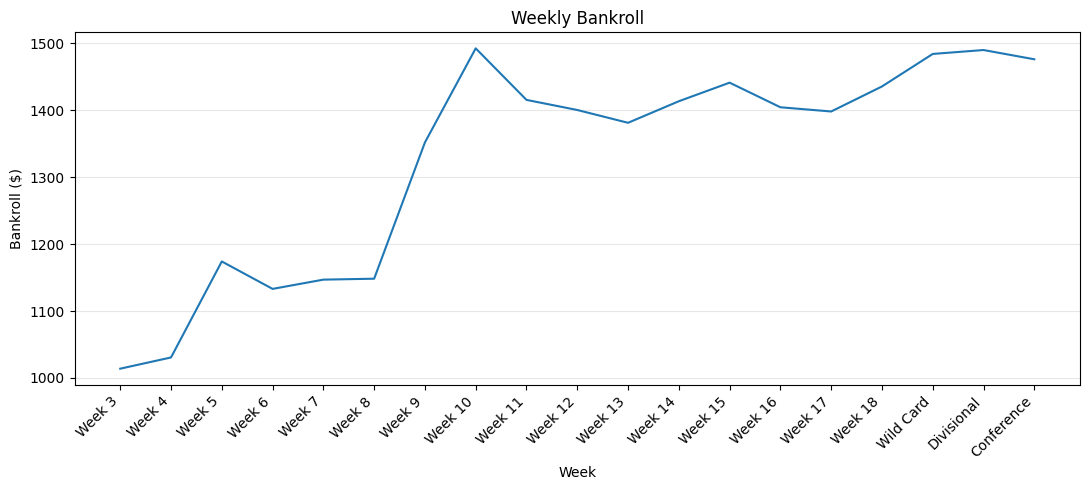

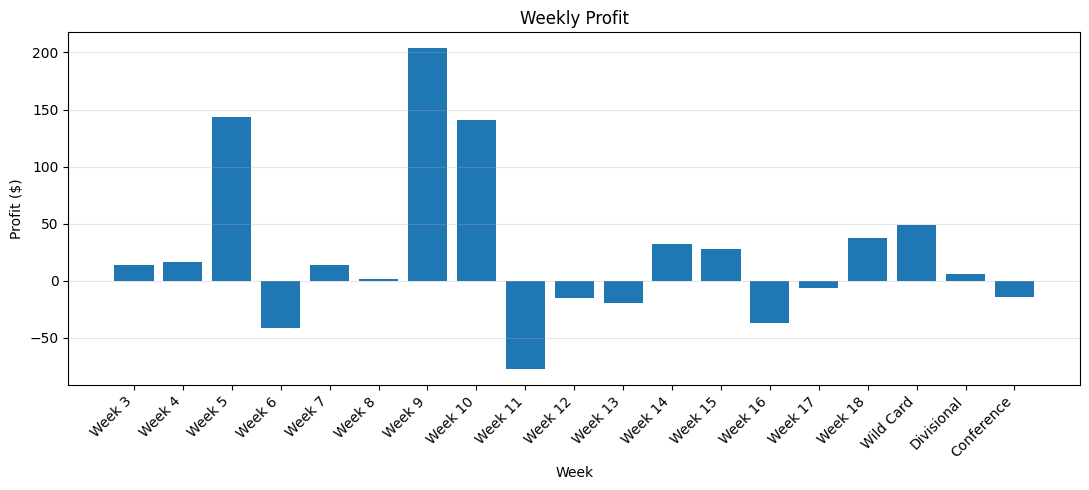

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

BETS_PATH = "bets_selected.csv"
INITIAL_BANKROLL = 1000.0

ORDER_LABELS = [f"Week {i}" for i in range(1,19)] + ["Wild Card","Divisional","Conference","Super Bowl"]
ORDER_INDEX  = {lab:i for i,lab in enumerate(ORDER_LABELS)}

def week_label_from_num(n: int):
    n = int(n)
    if 1 <= n <= 18: return f"Week {n}"
    return {19:"Wild Card",20:"Divisional",21:"Conference",22:"Super Bowl"}.get(n, f"Week {n}")

def week_sort_key(df):
    out = df.copy()
    if "week_label" in out.columns:
        out["week_label"] = out["week_label"].astype(str)
    elif "week" in out.columns:
        out["week_label"] = out["week"].apply(week_label_from_num).astype(str)
    else:
        out["week_label"] = "Week 999"
    out["week_order"] = out["week_label"].map(ORDER_INDEX).fillna(999).astype(int)
    return out

if not os.path.exists(BETS_PATH):
    raise FileNotFoundError("bets_selected.csv not found. Run Step 6 first or adjust BETS_PATH.")

bets = pd.read_csv(BETS_PATH, low_memory=False)

if "schedule_date" in bets.columns:
    bets["schedule_date"] = pd.to_datetime(bets["schedule_date"], errors="coerce")

if "profit" not in bets.columns:
    raise ValueError("CSV is missing the 'profit' column; cannot build weekly bankroll.")

bets["profit"] = pd.to_numeric(bets["profit"], errors="coerce").fillna(0.0)

wk = (bets.pipe(week_sort_key)
           .groupby("week_label", sort=False)
           .agg(profit=("profit","sum"),
                n_bets=("profit","size"))
           .reset_index())

wk = week_sort_key(wk).sort_values("week_order").reset_index(drop=True)

bk_seq = []
tmp = INITIAL_BANKROLL
for _, r in wk.iterrows():
    tmp = float(np.round(tmp + float(r["profit"]), 2))
    bk_seq.append(tmp)
wk["bankroll_week_close"] = bk_seq

final_bk = wk["bankroll_week_close"].iloc[-1] if not wk.empty else INITIAL_BANKROLL
total_profit = float(wk["profit"].sum()) if not wk.empty else 0.0

print(f"Initial bankroll: ${INITIAL_BANKROLL:,.2f}")
print(f"Final bankroll:   ${final_bk:,.2f}")
print(f"Total profit:     ${total_profit:,.2f}")

plt.figure(figsize=(11,5))
plt.plot(wk["week_label"], wk["bankroll_week_close"])
plt.title("Weekly Bankroll")
plt.xlabel("Week")
plt.ylabel("Bankroll ($)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(11,5))
plt.bar(wk["week_label"], wk["profit"])
plt.title("Weekly Profit")
plt.xlabel("Week")
plt.ylabel("Profit ($)")
plt.xticks(rotation=45, ha="right")
plt.grid(True, axis="y", alpha=0.3)
plt.tight_layout()
plt.show()


